## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

### Load CIFAR data
* cifar 10 - labelled subsets of a larger dataset which contains 10 categories of images
* Load training and test datasets
* Apply transforms
* Define dataloaders for training and testing

In [2]:
# See ImagePreprocessingPyTorch.ipynb

mean = [0.49140126, 0.4821608,  0.44652855]
std = [0.24703369, 0.24348529, 0.26158836]

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='datasets/cifar10/train',
                                        train=True,
                                        download=True,
                                        transform=train_transform)

Files already downloaded and verified


In [6]:
testset = torchvision.datasets.CIFAR10(root='datasets/cifar10/train',
                                       train=False,
                                       download=True,
                                       transform=test_transform)

Files already downloaded and verified


In [7]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=8,
                                          shuffle=True,
                                          num_workers=2)

In [8]:
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=8,
                                         shuffle=False,
                                         num_workers=2)

In [9]:
class_names = trainset.classes

print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
img, label = iter(trainloader).next()

In [11]:
img.shape

torch.Size([8, 3, 32, 32])

In [12]:
label

tensor([3, 3, 1, 5, 6, 8, 6, 0])

#### Configuring the neural network
* The input size will be the channels of the images (in_size)
* The final output will have a size equal to the number of classes for the prediction
* The convolving kernel will have a size of k_conv_size

In [13]:
in_size = 3

hid1_size = 16
hid2_size = 32

out1_size = 400
out2_size = 10

k_conv_size = 5

### Define the Convolutional Neural Network

<b>Conv2d: </b>Applies a 2D convolution over an input signal composed of several input planes.<br>
Parameters<br>
in_channels (int) – Number of channels in the input image<br>
out_channels (int) – Number of channels produced by the convolution<br>
kernel_size (int or tuple) – Size of the convolving kernel<br>

<b>BatchNorm2d: </b>Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension) as described in the paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift .
Parameters<br>
num_features – C from an expected input of size (N,C,H,W)

<b>ReLU: </b>Activation function

<b>Maxpool2d: </b>
Parameters:<br>
kernel_size – the size of the window to take a max over

<b>Linear: </b>
Parameter:<br>

in_features: 
All the operations above used 4D Tensors of shape 

Now for fully connected layers(linear layers) we need to transform them in 1D Tensors<br>
So to the in_features of fully connected layer we will give size
out_features:<br>
num_classes = number of output labels



In [38]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size), # Conv2D output = 28x28
            nn.BatchNorm2d(hid1_size),
            nn.ReLU(), # Re-run for nn.Sigmoid(), nn.Tanh(), nn.ELU()
            nn.MaxPool2d(kernel_size=2)) # MaxPool2D output = 14x14
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size), # Conv2D output = 10x10
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(), # Re-run for nn.Sigmoid(), nn.Tanh(), nn.ELU()
            nn.MaxPool2d(kernel_size=2)) # MaxPool2D output = 5x5
        
        self.layer3 = nn.Sequential(
            nn.Linear(hid2_size * k_conv_size * k_conv_size, out1_size), 
            nn.ReLU(), # Re-run for nn.Sigmoid(), nn.Tanh(), nn.ELU() 
            nn.Dropout(0.5), # dropout randomly 50% neurons
            nn.Linear(out1_size, out2_size))
        
        
    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.reshape(out.size(0), -1)
        
        out = self.layer3(out)
        
        return F.log_softmax(out, dim=-1)

In [15]:
model = ConvNet()

In [16]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


In [17]:
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=800, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=400, out_features=10, bias=True)
  )
)

In [22]:
learning_rate = 0.0001

criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

#### Training the model and predicting accuracy

In [23]:
total_step = len(trainloader)
num_epochs = 10
loss_values = list()

In [24]:
for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(trainloader):
        
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if (i+1) % 2000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
            loss_values.append(loss.item())

            
print('Finished Training')    

Epoch [1/10], Step [2000/6250], Loss: 0.7727
Epoch [1/10], Step [4000/6250], Loss: 0.5026
Epoch [1/10], Step [6000/6250], Loss: 1.1812
Epoch [2/10], Step [2000/6250], Loss: 0.5278
Epoch [2/10], Step [4000/6250], Loss: 0.4300
Epoch [2/10], Step [6000/6250], Loss: 1.4014
Epoch [3/10], Step [2000/6250], Loss: 0.4588
Epoch [3/10], Step [4000/6250], Loss: 1.0705
Epoch [3/10], Step [6000/6250], Loss: 1.0685
Epoch [4/10], Step [2000/6250], Loss: 0.8076
Epoch [4/10], Step [4000/6250], Loss: 0.7187
Epoch [4/10], Step [6000/6250], Loss: 0.7724
Epoch [5/10], Step [2000/6250], Loss: 0.8608
Epoch [5/10], Step [4000/6250], Loss: 1.1291
Epoch [5/10], Step [6000/6250], Loss: 0.2790
Epoch [6/10], Step [2000/6250], Loss: 1.9091
Epoch [6/10], Step [4000/6250], Loss: 1.0992
Epoch [6/10], Step [6000/6250], Loss: 0.8056
Epoch [7/10], Step [2000/6250], Loss: 1.0346
Epoch [7/10], Step [4000/6250], Loss: 0.7979
Epoch [7/10], Step [6000/6250], Loss: 0.6744
Epoch [8/10], Step [2000/6250], Loss: 0.3483
Epoch [8/1

### Evaluate Model

Text(0, 0.5, 'Loss')

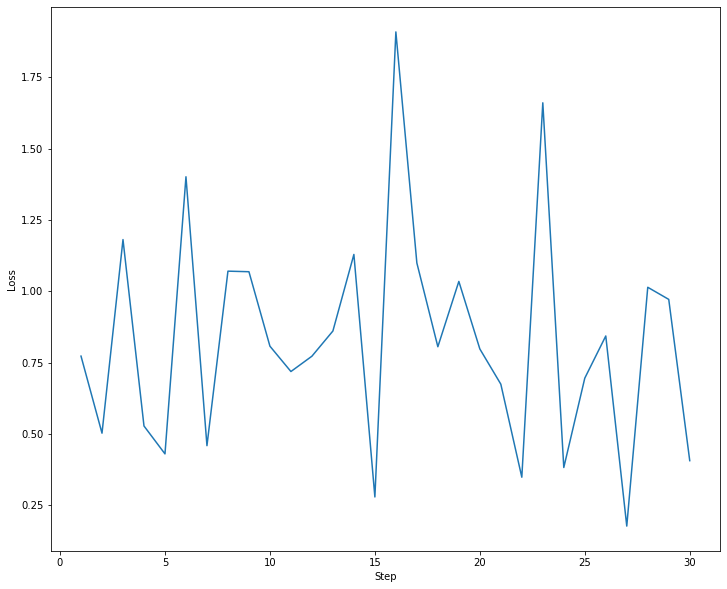

In [25]:
x = (range(1, 31))

plt.figure(figsize = (12, 10))

plt.plot(x, loss_values)
plt.xlabel('Step')
plt.ylabel('Loss')

In [26]:
model.eval()  # do not forget this line when evaluating model

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the 10000 test images: {}%'\
          .format(100 * correct / total))


Accuracy of the model on the 10000 test images: 75.78%


#### Sample Prediction

In [27]:
sample_img, _ = testset[23]

In [28]:
sample_img.shape

torch.Size([3, 32, 32])

In [29]:
sample_img = np.transpose(sample_img, (1, 2, 0))

In [30]:
m, M = sample_img.min(), sample_img.max()

sample_img = (1/(abs(m) * M)) * sample_img + 0.5 

In [31]:
sample_img

tensor([[[0.3205, 0.3665, 0.4492],
         [0.3166, 0.3154, 0.3687],
         [0.3244, 0.3390, 0.3980],
         ...,
         [0.3050, 0.3154, 0.3724],
         [0.4445, 0.4687, 0.5151],
         [0.5298, 0.5631, 0.6140]],

        [[0.3244, 0.3508, 0.4126],
         [0.3283, 0.3232, 0.3614],
         [0.3128, 0.3311, 0.3834],
         ...,
         [0.6849, 0.6890, 0.6762],
         [0.8167, 0.8266, 0.8007],
         [0.8283, 0.8423, 0.8190]],

        [[0.3360, 0.3508, 0.3834],
         [0.3515, 0.3429, 0.3651],
         [0.2856, 0.3075, 0.3541],
         ...,
         [0.8128, 0.8187, 0.7641],
         [0.7353, 0.7362, 0.6872],
         [0.6926, 0.6968, 0.6433]],

        ...,

        [[0.6577, 0.6693, 0.6469],
         [0.6577, 0.6732, 0.6469],
         [0.6500, 0.6654, 0.6359],
         ...,
         [0.6345, 0.6339, 0.6103],
         [0.6267, 0.6260, 0.6066],
         [0.6035, 0.6024, 0.5810]],

        [[0.6151, 0.6260, 0.6176],
         [0.6539, 0.6654, 0.6506],
         [0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


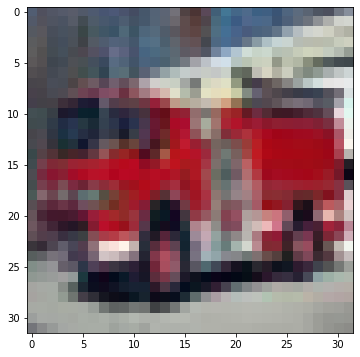

In [32]:
plt.figure(figsize = (6, 6))
plt.imshow(sample_img)

In [33]:
test_img, test_label = testset[23]

test_img = test_img.reshape(-1, 3, 32, 32)

In [34]:
out_predict = model(test_img.to(device))
_,predicted = torch.max(out_predict.data, 1)

In [35]:
print("Actual Label : ", test_label)

Actual Label :  9


In [36]:
print("Predicted Label : " ,predicted.item())

Predicted Label :  9


In [37]:
print("Class name for {} : {}".format( predicted.item(), class_names[predicted.item()]))

Class name for 9 : truck
